In [12]:
import nltk, re, string
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords
# numpy is the package for matrix cacluation
import numpy as np  
# for lemma
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
wordnet_lemmatizer = WordNetLemmatizer()
# import cross validation method
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB

# import pipeline class
from sklearn.pipeline import Pipeline

# import GridSearch
from sklearn.model_selection import GridSearchCV

text = []
target = []
import csv
with open('amazon_review_300.csv', 'rb') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        text.append(row[2])
        target.append(row[0])
#print(text[0])
#print(target[0])


from sklearn.feature_extraction.text import TfidfVectorizer

# initialize the TfidfVectorizer 

tfidf_vect = TfidfVectorizer() 

# with stop words removed
tfidf_vect = TfidfVectorizer(stop_words="english") 

# generate tfidf matrix
dtm= tfidf_vect.fit_transform(text)
#dtm here contains the tfidf matrix using vectoriser
print("type of dtm:", type(dtm))
print("size of tfidf matrix:", dtm.shape)

#############  Multinomial NB Starts here

metrics = ['precision_macro', 'recall_macro', "f1_macro"]

#create the classifier
#clf = MultinomialNB()
clf = MultinomialNB(alpha=0.5)

cv = cross_validate(clf, dtm, target, scoring=metrics, cv=7)
print("**************MultinomialNB using vector with CV = 7*******************")
print("Test data set average precision:")
print(cv['test_precision_macro'])
print(np.average(cv['test_precision_macro']))
print("\nTest data set average recall:")
print(cv['test_recall_macro'])
print(np.average(cv['test_recall_macro']))
print("\nTest data set average fscore:")
print(cv['test_f1_macro'])


def get_doc_tokens(doc):
    lemmatized = True;
    stop_words = stopwords.words('english')
    if(lemmatized == True):
        tokens=[token.strip() \
            for token in nltk.word_tokenize(doc.lower()) \
            if token.strip() not in stop_words and\
               token.strip() not in string.punctuation]
        #tokens = lemma(doc)
        tagged_tokens= nltk.pos_tag(tokens)
        #print("********************TAgged Tokens***********************")
        #print(tagged_tokens)
        le_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) \
          # tagged_tokens is a list of tuples (word, tag)
          for (word, tag) in tagged_tokens \
          # remove stop words
          if word not in stop_words and \
          # remove punctuations
          word not in string.punctuation]
          # get lemmatized unique tokens as vocabulary
        le_vocabulary=set(le_words)
        tokens = list(le_vocabulary)
    
    else:
        #stop_words = stopwords.words('english')
        tokens=[token.strip() \
            for token in nltk.word_tokenize(doc.lower()) \
            if token.strip() not in stop_words and\
               token.strip() not in string.punctuation]
    # you can add bigrams, collocations, or lemmatization here
    #print("******************** Tokens***********************")
    return tokens

def get_wordnet_pos(pos_tag): # 'JJ','NN'
    
    # if pos tag starts with 'J'
    if pos_tag.startswith('J'):
        # return wordnet tag "ADJ"
        return wordnet.ADJ
    
    # if pos tag starts with 'V'
    elif pos_tag.startswith('V'):
        # return wordnet tag "VERB"
        return wordnet.VERB
    
    # if pos tag starts with 'N'
    elif pos_tag.startswith('N'):
        # return wordnet tag "NOUN"
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        # be default, return wordnet tag "NOUN"
        return wordnet.NOUN

    
        
def tfidf(text):
    # step 2. process all documents to get list of token list
    docs_tokens=[get_doc_tokens(doc) for doc in text]
    #print(docs_tokens)
    voc=list(set([token for tokens in docs_tokens \
              for token in tokens]))
    dtm2=np.zeros((len(text), len(voc)))
    #print(voc)
   
    
    for row_index,tokens in enumerate(docs_tokens):
        for token in tokens:
            col_index=voc.index(token)
            dtm2[row_index, col_index]+=1
            #print(row_index , col_index , dtm[row_index, col_index])
    print("*********************Length of the Matrix*****************************")
    print(dtm2.shape)
       
    # step 4. get normalized term frequency (tf) matrix        
    doc_len=dtm2.sum(axis=1, keepdims=True)
    tf=np.divide(dtm2, doc_len)
    
    
    # step 5. get idf
    doc_freq=np.copy(dtm2)
    doc_freq[np.where(doc_freq>0)]=1

    smoothed_idf=np.log(np.divide(len(text)+1, np.sum(doc_freq, axis=0)+1))+1

    
    # step 6. get tf-idf
    smoothed_tf_idf=normalize(tf*smoothed_idf)
    return smoothed_tf_idf

smoothed_tf_idf = tfidf(text)

metrics = ['precision_macro', 'recall_macro', "f1_macro"]

#clf = MultinomialNB()
clf = MultinomialNB(alpha=0.5)

cv = cross_validate(clf, smoothed_tf_idf, target, scoring=metrics, cv=5)
print("**************MultinomialNB using 3rd Assignment*******************")
print("Test data set average precision:")
print(cv['test_precision_macro'])
print(np.average(cv['test_precision_macro']))
print("\nTest data set average recall:")
print(cv['test_recall_macro'])
print(np.average(cv['test_recall_macro']))
print("\nTest data set average fscore:")
print(cv['test_f1_macro'])
print(np.average(cv['test_f1_macro']))


text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())
                   ]) 





('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (300, 3805))
**************MultinomialNB using vector with CV = 5*******************
Test data set average precision:
[ 0.66282051  0.81493506  0.66282051  0.67708333  0.79638009  0.62731481
  0.80357143]
0.720703679685

Test data set average recall:
[ 0.63804348  0.81630435  0.63804348  0.66630435  0.78478261  0.61956522
  0.77231121]
0.705050670154

Test data set average fscore:
[ 0.63121784  0.81385281  0.63121784  0.66555556  0.78654164  0.61777778
  0.77540107]
*********************Length of the Matrix*****************************
(300L, 3573L)
**************MultinomialNB using 3rd Assignment*******************
Test data set average precision:
[ 0.67424242  0.78282828  0.64857143  0.675       0.73067633]
0.702263692829

Test data set average recall:
[ 0.66179654  0.78125     0.64508929  0.65625     0.72106481]
0.693090127465

Test data set average fscore:
[ 0.66111111  0.78181818  0.64517037  0.65277

In [13]:
print("*************text_clf*******************")

parameters = {'tfidf__min_df':[1,2,3],
              'tfidf__stop_words':[None,"english"],
              'clf__alpha': [0.5,1.0,1.5,2.0],
}

# the metric used to select the best parameters
metric =  "f1_macro"

# GridSearch also uses cross validation
gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)

# due to data volume and large parameter combinations
# it may take long time to search for optimal parameter combination
# you can use a subset of data to test
gs_clf = gs_clf.fit(text, target)

for param_name in gs_clf.best_params_:
    print(param_name,": ",gs_clf.best_params_[param_name])

print("best f1 score:", gs_clf.best_score_)

*************text_clf*******************
('tfidf__stop_words', ': ', None)
('tfidf__min_df', ': ', 3)
('clf__alpha', ': ', 0.5)
('best f1 score:', 0.74038261618491519)


In [14]:
#This is the last part.Here we will be plotting the performance

import matplotlib.pyplot as plt
text_large=[]
target_large=[]
with open('amazon_review_large.csv', 'rb') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        text_large.append(row[1])
        target_large.append(row[0])
#print(text[0])
#print(target[0])


    

('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (300, 3805))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (600, 6072))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (900, 7445))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (1200, 8762))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (1500, 10209))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (1800, 11429))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (2100, 12429))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (2400, 13601))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (2700, 14571))
('type of dtm:', <class 'scipy.sparse.csr.csr_matrix'>)
('size of tfidf matrix:', (3000, 15498))
('type of dtm:', <class 'scipy.sparse

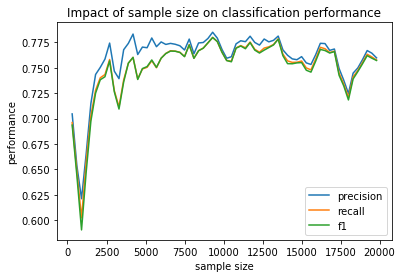

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
recallList = []
precisionList=[]
f1List = []
metrics = []
# We take increase 300 samples each time and see at what at what 
#point we get a constant performance
for i in range(300,len(text_large),300):
    newList = []
    start = 0
    #Get the sample to be computed
    sample=text_large[:i]
    target_large1 = target_large[:i]
    #print(len(sample))
    # initialize the TfidfVectorizer
    tfidf_vect_large = TfidfVectorizer() 

    # with stop words removed
    tfidf_vect_large = TfidfVectorizer(stop_words="english") 

    # generate tfidf matrix
    dtm_large= tfidf_vect.fit_transform(sample)
    #dtm here contains the tfidf matrix using vectoriser
    print("type of dtm:", type(dtm_large))
    print("size of tfidf matrix:", dtm_large.shape)
    metrics_large = ['precision_macro', 'recall_macro', "f1_macro"]

    #clf = MultinomialNB()
    clf_large = MultinomialNB(alpha=0.5)

    cv1 = cross_validate(clf_large, dtm_large, target_large1, scoring=metrics_large, cv=10)
    #print("**************MultinomialNB using vector with CV = 5*******************")
    #print("Test data set average precision:")
    #print(cv1['test_precision_macro'])
    #print(np.average(cv1['test_precision_macro']))
    
    #print("\nTest data set average recall:")
    #print(cv1['test_recall_macro'])
    #print(np.average(cv1['test_recall_macro']))
                      
    #print("\nTest data set average fscore:")
    #print(cv1['test_f1_macro'])
    newList.append(i)
    newList.append(np.average(cv1['test_precision_macro']))
    newList.append(np.average(cv1['test_recall_macro']))
    newList.append(np.average(cv1['test_f1_macro']))
    metrics.append(newList)
    
    
#print(metrics)
#now we plot the performance graph
results=np.array(metrics)
plt.plot(results[:,0], results[:,1], '-', label='precision')
plt.plot(results[:,0], results[:,2], '-', label='recall')
plt.plot(results[:,0], results[:,3], '-', label='f1')
plt.title('Impact of sample size on classification performance')
plt.ylabel('performance')
plt.xlabel('sample size')
plt.legend()
plt.show()


    